In [3]:
import librosa
import pandas as pd
import dask.dataframe as dd
import numpy as np
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
import optuna
import webrtcvad
import torch
from silero_vad import get_speech_timestamps, load_silero_vad, VADIterator
from dask.distributed import LocalCluster, Client
from collections import defaultdict
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from globals import *

In [4]:
SAMPLE_RATE = 16000
FRAME_SIZE = 512
HOP_LENGTH = 256
QUT_NOISE_TIMIT_PATH = '../QUT-NOISE'
ESC_50_PATH = 'ESC-50'
FSD_NOISY_PATH = 'FSDnoisy18k'

# Предисловие

Распознавание речевой активности (Voice Activity Detection, VAD) представляет собой задачу автоматического определения участков аудиосигнала, содержащих речь. Иными словами, VAD позволяет отличить фрагменты, где человек говорит, от тишины, фонового шума или других неречевых звуков. Данная задача является предварительным этапом в большинстве современных систем обработки и анализа речи.

В рамках данной работы будет исследован подход к VAD, основанный на использовании модели градиентного бустинга на решающих деревьях - LightGBM. В работе:
* Будут выбраны датасеты для обучения модели.
* Будет произведена подготовка тренировочных и тестовых аудиоданных: разбиение на кадры, разметка на речевые и неречевые сегменты и извлечение признаков.
* Будет проведено обучение модели LightGBM на подготовленных тренировочных данных и произведена настройка гиперпараметров.
* Будет проведено тестирование модели LightGBM на подготовленных тестовых данных.
* Будет реализован инференс обученной модели: создано графическое приложение, которое в реальном времени выполняет обнаружение речи в аудиопотоке с микрофона при помощи трёх моделей на выбор: обученной здесь LightGBM, популярной модели WebRTC VAD и модели Silero VAD. 

# Препроцессинг

На данном этапе производится выбор подходящих датасетов, нормализация аудио, разметка речевых и неречевых сегментов, а также извлечение признаков для обучения.

В данной работе были использованы три открытых набора аудиоданных, охватывающих как речевые, так и неречевые звуки.

In [5]:
def load_qut_noise_timit_files(batches, durations, snrs):
    files = []
    for batch in batches:
        with open(f'{QUT_NOISE_TIMIT_PATH}/code/QUT-NOISE-TIMIT.t{batch}.wavlist') as f:
            for line in f:
                if not line:
                    continue
                path, _ = os.path.splitext(line)
                duration = int(path.split('/')[2][1:])
                if duration not in durations:
                    continue
                snr = int(path.split('/')[3][1:])
                if snr not in snrs:
                    continue
                full_path = QUT_NOISE_TIMIT_PATH + '/QUT-NOISE-TIMIT/' + path
                files.append(
                    {
                        'audio_path': full_path + '.wav',
                        'labels_path': full_path + '.eventlab'
                    }
                )
    return files

def load_esc_50_files(folds, categories):
    files = []
    esc_50_meta_df = pd.read_csv(f'{ESC_50_PATH}/meta/esc50.csv')
    esc_50_meta_df = esc_50_meta_df[(esc_50_meta_df['fold'].isin(folds)) & (esc_50_meta_df['category'].isin(categories))]
    for file in esc_50_meta_df['filename']:
        full_path = ESC_50_PATH + '/audio/' + file
        files.append(
            {
                'audio_path': full_path,
                'labels_path': ''
            }
        )
    return files

def load_fsd_noisy_files(is_train):
    files = []
    if is_train:
        fsd_noisy_meta_df = pd.read_csv(f'{FSD_NOISY_PATH}/meta/train.csv')
        fsd_noisy_meta_df = fsd_noisy_meta_df[fsd_noisy_meta_df['manually_verified'] == 1]
    else:
        fsd_noisy_meta_df = pd.read_csv(f'{FSD_NOISY_PATH}/meta/test.csv')
    
    for file in fsd_noisy_meta_df['fname']:
        full_path = FSD_NOISY_PATH + ('/audio_train/' if is_train else '/audio_test/') + file
        files.append(
            {
                'audio_path': full_path,
                'labels_path': ''
            }
        )
    return files

## QUT-NOISE-TIMIT

QUT-NOISE-TIMIT - синтетический набор данных, полученный путём наложения реальных шумов окружающей среды (набор данных QUT-NOISE) на аудио, содержащее человеческий голос (набор данных TIMIT). Содержит точную разметку речевых участков.

Из QUT-NOISE-TIMIT были выбраны аудиофайлы длиной 60 секунд с различными уровнями отношения сигнал/шум (SNR):
* Для обучающей выборки использовалась $3/4$ часть набора данных с $\text{SNR} = \{0, 5, 10, 15\}$.
* Для тестовой выборки использовалась $1/4$ часть набора данных с $\text{SNR} = \{-10, -5, 0, 5, 10, 15\}$.

SNR (Signal-to-Noise Ratio) - это метрика, характеризующая отношение мощности сигнала к мощности шума. Выражается в децибелах:
\begin{equation}
    \text{SNR(дБ)} = 10 * \log_{10}\left(\frac{P_\text{сигнала}}{P_\text{шума}}\right)
\end{equation}

После этого из полученного датасета были взяты случайные $10\%$ данных.

In [6]:
QUT_NOISE_TIMIT_SIZE_RATIO = 0.1

train_qut_noise_timit_files = load_qut_noise_timit_files([1, 2, 3], [60], [0, 5, 10, 15])
test_qut_noise_timit_files = load_qut_noise_timit_files([4], [60], [-10, -5, 0, 5, 10, 15])

train_qut_noise_timit_files_df = pd.DataFrame(train_qut_noise_timit_files)
train_qut_noise_timit_files_df = train_qut_noise_timit_files_df.sample(frac=QUT_NOISE_TIMIT_SIZE_RATIO, random_state=42, ignore_index=True)
train_qut_noise_timit_files_df['is_train'] = True

test_qut_noise_timit_files_df = pd.DataFrame(test_qut_noise_timit_files)
test_qut_noise_timit_files_df = test_qut_noise_timit_files_df.sample(frac=QUT_NOISE_TIMIT_SIZE_RATIO, random_state=42, ignore_index=True)
test_qut_noise_timit_files_df['is_train'] = False

qut_noise_timit_files_df = pd.concat([train_qut_noise_timit_files_df, test_qut_noise_timit_files_df], ignore_index=True)

percentages = (qut_noise_timit_files_df['is_train'].value_counts(normalize=True)) * 100
print(percentages)
qut_noise_timit_files_df

is_train
True     66.666667
False    33.333333
Name: proportion, dtype: float64


,audio_path,labels_path,is_train
0,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-CITY-1/sA/...,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-CITY-1/sA/...,True
1,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-CITY-2/sB/...,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-CITY-2/sB/...,True
2,../QUT-NOISE/QUT-NOISE-TIMIT/CAFE-FOODCOURTB-1...,../QUT-NOISE/QUT-NOISE-TIMIT/CAFE-FOODCOURTB-1...,True
3,../QUT-NOISE/QUT-NOISE-TIMIT/CAFE-FOODCOURTB-2...,../QUT-NOISE/QUT-NOISE-TIMIT/CAFE-FOODCOURTB-2...,True
4,../QUT-NOISE/QUT-NOISE-TIMIT/REVERB-CARPARK-1/...,../QUT-NOISE/QUT-NOISE-TIMIT/REVERB-CARPARK-1/...,True
...,...,...,...
895,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,False
896,../QUT-NOISE/QUT-NOISE-TIMIT/CAR-WINUPB-2/sA/l...,../QUT-NOISE/QUT-NOISE-TIMIT/CAR-WINUPB-2/sA/l...,False
897,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,False
898,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,../QUT-NOISE/QUT-NOISE-TIMIT/STREET-KG-2/sA/l0...,False


## ESC-50

ESC-50 - набор бытовых звуков, сгруппированных по категориям (животные, машины, окружающая среда и др.). Из датасета ESC-50 были выбраны шесть классов неречевых звуков: самолёты, собаки, коровы, кошки, пение птиц, двигатели. Для обучения использовались аудиофайлы из фолдов 1, 2, 3, 4. Для тестирования - фолд 5.

In [7]:
categories = ['airplane', 'dog', 'cow', 'cat', 'chirping_birds', 'engine']
train_esc_50_files = load_esc_50_files([1, 2, 3, 4], categories)
test_esc_50_files = load_esc_50_files([5], categories)

train_esc_50_files_df = pd.DataFrame(train_esc_50_files)
train_esc_50_files_df['is_train'] = True

test_esc_50_files_df = pd.DataFrame(test_esc_50_files)
test_esc_50_files_df['is_train'] = False

esc_50_files_df = pd.concat([train_esc_50_files_df, test_esc_50_files_df], ignore_index=True)

percentages = (esc_50_files_df['is_train'].value_counts(normalize=True)) * 100
print(percentages)
esc_50_files_df

is_train
True     80.0
False    20.0
Name: proportion, dtype: float64


,audio_path,labels_path,is_train
0,ESC-50/audio/1-100032-A-0.wav,,True
1,ESC-50/audio/1-100038-A-14.wav,,True
2,ESC-50/audio/1-110389-A-0.wav,,True
3,ESC-50/audio/1-11687-A-47.wav,,True
4,ESC-50/audio/1-16568-A-3.wav,,True
...,...,...,...
235,ESC-50/audio/5-253085-B-3.wav,,False
236,ESC-50/audio/5-256452-A-5.wav,,False
237,ESC-50/audio/5-257839-A-14.wav,,False
238,ESC-50/audio/5-259169-A-5.wav,,False


## FSDnoisy18k

FSDnoisy18k - набор пользовательских аудиоклипов с сайта Freesound, часть из которых вручную подтверждена. Для обучения использовались все вручную проверенные (manually verified) данные из тренировочного поднабора. Для тестирования - все данные из тестового поднабора.

In [8]:
train_fsd_noisy_files = load_fsd_noisy_files(True)
test_fsd_noisy_files = load_fsd_noisy_files(False)

train_fsd_noisy_files_df = pd.DataFrame(train_fsd_noisy_files)
train_fsd_noisy_files_df['is_train'] = True

test_fsd_noisy_files_df = pd.DataFrame(test_fsd_noisy_files)
test_fsd_noisy_files_df['is_train'] = False

fsd_noisy_files_df = pd.concat([train_fsd_noisy_files_df, test_fsd_noisy_files_df], ignore_index=True)

percentages = (fsd_noisy_files_df['is_train'].value_counts(normalize=True)) * 100
print(percentages)
fsd_noisy_files_df

is_train
True     65.171019
False    34.828981
Name: proportion, dtype: float64


,audio_path,labels_path,is_train
0,FSDnoisy18k/audio_train/94322.wav,,True
1,FSDnoisy18k/audio_train/85602.wav,,True
2,FSDnoisy18k/audio_train/240356.wav,,True
3,FSDnoisy18k/audio_train/371015.wav,,True
4,FSDnoisy18k/audio_train/264589.wav,,True
...,...,...,...
2714,FSDnoisy18k/audio_test/235535.wav,,False
2715,FSDnoisy18k/audio_test/326043.wav,,False
2716,FSDnoisy18k/audio_test/62469.wav,,False
2717,FSDnoisy18k/audio_test/273450.wav,,False


## Извлечение признаков

**Общие параметры предобработки**

Для всех аудиофайлов использовались следующие настройки:
* Частота дискретизации (sample rate): $16000$ Гц.
* Размер окна (frame size): $512$ семплов.
* Шаг между окнами (hop length): $256$ семплов.

Таким образом, каждый фрейм охватывает $32$ мс сигнала при перекрытии в $50\%$.

**Разметка аудио**

Для QUT-NOISE-TIMIT использовалась официальная разметка речевых сегментов, представленная в виде временных меток. Для ESC-50 и FSDnoisy18k все фреймы помечались как неречевые.
После объединения всех фреймов из трёх датасетов для каждого фрейма была сформирована бинарная метка: $1$ - если фрейм содержит речь, $0$ - если нет.

**Извлечение признаков**

Для каждого фрейма извлекались следующие признаки:
* $13$ MFCC (Mel-Frequency Cepstral Coefficients)
* $13$ дельта-MFCC (первых производных)
* $13$ $\text{дельта}^2$-MFCC (вторых производных)
* RMS (Root Mean Square Energy)
* ZCR (Zero-Crossing Rate)
* ZRMSE $= \frac{\text{RMS}}{\text{ZCR} + \varepsilon}$

Итоговый размер вектора признаков на один фрейм $= 42$.

Поскольку объём аудиоданных значителен, весь процесс предварительной обработки (включая чтение файлов, фрейминг, извлечение признаков и объединение в единую таблицу) был реализован в параллельном режиме с использованием библиотеки Dask, что обеспечило масштабируемость и ускорение подготовки выборки.

In [9]:
cluster = LocalCluster(
    n_workers=psutil.cpu_count(logical=False),
    threads_per_worker=2,
    memory_limit="4GB"
)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52520,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52547,Total threads: 2
Dashboard: http://127.0.0.1:52554/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:52523,


In [10]:
files_df = pd.concat([qut_noise_timit_files_df, esc_50_files_df, fsd_noisy_files_df], ignore_index=True)
files_df = files_df.sample(frac=1).reset_index(drop=True)

files_ddf = dd.from_pandas(
    files_df,
    npartitions=4*psutil.cpu_count(logical=False)
)
files_ddf

,audio_path,labels_path,is_train
npartitions=24,,,
0,string,string,bool
161,...,...,...
...,...,...,...
3699,...,...,...
3858,...,...,...


In [ ]:
def extract_features(y):
    features = []

    n_mfcc = 13
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=n_mfcc, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False)
    mfcc_delta1 = librosa.feature.delta(mfcc).T
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2).T
    mfcc = mfcc.T

    rms = librosa.feature.rms(y=y, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH, center=False).T
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH, center=False).T

    eps = 1e-6
    zrmse = rms / (zcr + eps)

    features = np.hstack([mfcc, mfcc_delta1, mfcc_delta2, rms, zcr, zrmse])
    columns = [f"mfcc_{i+1}" for i in range(n_mfcc)] + \
              [f"mfcc_delta1_{i+1}" for i in range(n_mfcc)] + \
              [f"mfcc_delta2_{i+1}" for i in range(n_mfcc)] + \
              ["rms",
               "zcr",
               "zrmse"]
    
    return pd.DataFrame(features, columns=columns)

def process_audio(audio_path, labels_path, is_train):
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)

    n_frames = 1 + (len(y) - FRAME_SIZE) // HOP_LENGTH
    labels = np.zeros(n_frames, dtype=np.int8)
    if labels_path:
        with open(labels_path, 'r') as f:
            label_data = f.read()
        for line in label_data.split('\n'):
            if not line:
                continue
            start, end, is_speech = line.strip().split()
            if is_speech != 'speech':
                continue
            start_frame = librosa.time_to_frames(float(start), sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
            end_frame = librosa.time_to_frames(float(end), sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
            labels[start_frame:end_frame] = 1

    processed_df = extract_features(y)
    processed_df["is_train"] = is_train
    processed_df["is_speech"] = labels  
    
    return processed_df
            

def process_partition(df, partition_info=None):
    partition_id = partition_info['number']
    total = df.shape[0]

    i = 1
    results = []
    for row in df.itertuples():
        processed_df = process_audio(row.audio_path, row.labels_path, row.is_train)
        results.append(processed_df)
        print(f"[Partition {partition_id}]: {i}/{total}")
        i += 1
    
    return pd.concat(results)


In [ ]:
y = np.random.randn(SAMPLE_RATE)
features_df = extract_features(y)
features_df["is_train"] = False
features_df["is_speech"] = 0

meta = features_df.iloc[:0]

ddf = files_ddf.map_partitions(
    process_partition,
    meta=meta,
    partition_info=True
)

ddf.to_parquet(
    'data.parquet',
    write_index=False,
    overwrite=True
)

client.close()
cluster.close()

[Partition 5]: 1/161
[Partition 1]: 1/161
[Partition 5]: 2/161
[Partition 5]: 3/161
[Partition 1]: 2/161
[Partition 1]: 3/161
[Partition 1]: 4/161
[Partition 1]: 5/161
[Partition 1]: 6/161
[Partition 1]: 7/161
[Partition 1]: 8/161
[Partition 5]: 4/161
[Partition 1]: 9/161
[Partition 5]: 5/161
[Partition 5]: 6/161
[Partition 1]: 10/161
[Partition 1]: 11/161
[Partition 1]: 12/161
[Partition 1]: 13/161
[Partition 1]: 14/161
[Partition 1]: 15/161
[Partition 1]: 16/161
[Partition 1]: 17/161
[Partition 1]: 18/161
[Partition 1]: 19/161
[Partition 1]: 20/161
[Partition 5]: 7/161
[Partition 5]: 8/161
[Partition 5]: 9/161
[Partition 5]: 10/161
[Partition 5]: 11/161
[Partition 1]: 21/161
[Partition 1]: 22/161
[Partition 1]: 23/161
[Partition 5]: 12/161
[Partition 5]: 13/161
[Partition 5]: 14/161
[Partition 5]: 15/161
[Partition 1]: 24/161
[Partition 1]: 25/161
[Partition 1]: 26/161
[Partition 1]: 27/161
[Partition 5]: 16/161
[Partition 5]: 17/161
[Partition 5]: 18/161
[Partition 1]: 28/161
[Parti

# Анализ обработанных данных

В результате обработки был получен датасет, состоящий из $4288243$ фреймов - около $38$ часов аудио. Тренировочные данные составляют около $66\%$ датасета, тестовые - около $34\%$. Голосовых фреймов около $35\%$, без  голоса - около $65\%$.

In [11]:
df = pd.read_parquet('data.parquet')
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_delta2_9,mfcc_delta2_10,mfcc_delta2_11,mfcc_delta2_12,mfcc_delta2_13,rms,zcr,zrmse,is_train,is_speech
0,-372.717163,74.500763,9.991165,41.987457,-6.685750,-7.972415,11.330792,15.169222,-4.743447,-12.673062,...,-0.111637,-0.285569,-0.507139,-0.11227,0.551259,0.018645,0.158203,0.117855,True,0
1,-369.335876,87.376984,11.112087,23.478199,-7.788410,-7.293724,9.177170,11.108704,-7.566891,-0.884770,...,-0.111637,-0.285569,-0.507139,-0.11227,0.551259,0.018332,0.150391,0.121893,True,0
2,-378.190430,72.836868,7.332242,37.947334,1.190295,1.123389,1.231707,3.599339,-9.899860,-1.540133,...,-0.111637,-0.285569,-0.507139,-0.11227,0.551259,0.018218,0.126953,0.143498,True,0
3,-371.547577,67.875412,19.391026,28.441189,13.956988,-2.966289,-4.880713,0.142508,-5.423269,5.418490,...,-0.111637,-0.285569,-0.507139,-0.11227,0.551259,0.017292,0.132812,0.130197,True,0
4,-387.209229,70.860786,24.157404,33.062202,9.247808,4.202374,-3.367503,3.756446,0.101951,-2.754561,...,-0.111637,-0.285569,-0.507139,-0.11227,0.551259,0.014614,0.128906,0.113365,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288238,-673.029968,72.578217,50.174866,35.386410,36.799038,46.052795,49.429062,41.947578,29.680538,21.326256,...,-1.507347,-1.357950,-1.389361,-1.45735,-1.065954,0.034761,0.003906,8.896467,False,0
4288239,-692.032898,46.470108,28.145599,21.695644,30.715752,40.551376,38.833420,29.194241,23.133810,24.841129,...,-1.507347,-1.357950,-1.389361,-1.45735,-1.065954,0.024337,0.001953,12.454023,False,0
4288240,-688.666321,50.174835,28.228888,15.699267,19.202957,28.924583,33.618416,30.873711,24.536705,19.146406,...,-1.507347,-1.357950,-1.389361,-1.45735,-1.065954,0.010022,0.003906,2.565102,False,0
4288241,-694.803955,38.355217,11.160180,-0.929383,10.768095,29.356440,35.246613,26.747879,16.413250,13.896263,...,-1.507347,-1.357950,-1.389361,-1.45735,-1.065954,0.005606,0.003906,1.434743,False,0


In [12]:
train_data = df[df['is_train']].drop(columns=['is_train'])
test_data = df[~df['is_train']].drop(columns=['is_train'])

X_train, y_train = train_data.drop(columns=['is_speech']), train_data['is_speech']
X_test, y_test = test_data.drop(['is_speech'], axis=1), test_data['is_speech']

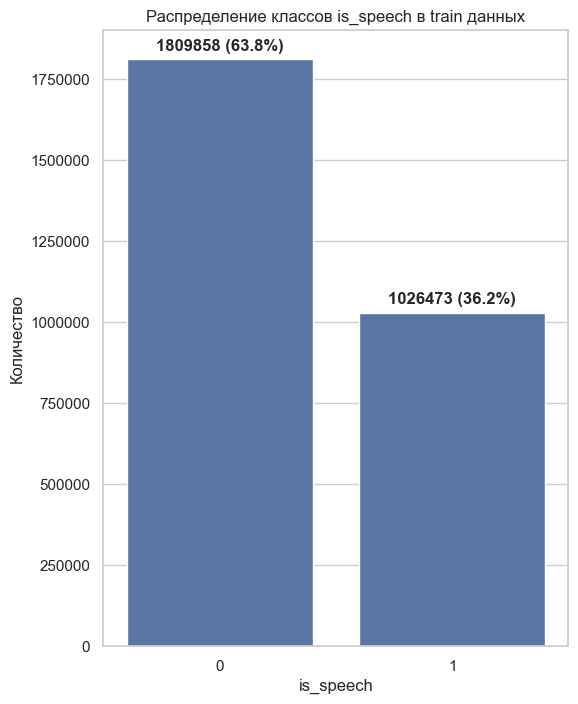

In [ ]:
counts = train_data['is_speech'].value_counts()
total = counts.sum()
percentages = counts / total * 100

sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
ax = sns.barplot(x=counts.index, y=counts.values)

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xlabel("is_speech")
plt.ylabel("Количество")
plt.title("Распределение классов is_speech в train данных")

for i, (abs_val, pct) in enumerate(zip(counts.values, percentages.values)):
    plt.text(i, abs_val + total * 0.01, f"{abs_val} ({pct:.1f}%)", ha='center', fontweight='bold')

plt.show()

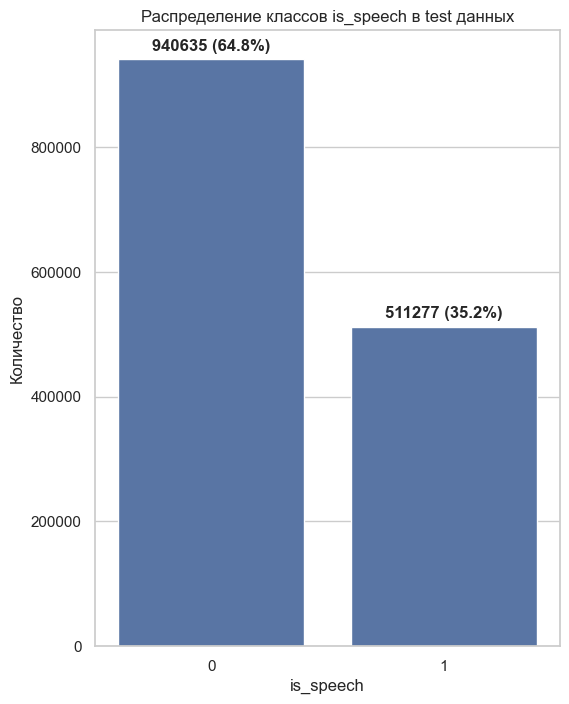

In [ ]:
counts = test_data['is_speech'].value_counts()
total = counts.sum()
percentages = counts / total * 100

sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
ax = sns.barplot(x=counts.index, y=counts.values)

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xlabel("is_speech")
plt.ylabel("Количество")
plt.title("Распределение классов is_speech в test данных")

for i, (abs_val, pct) in enumerate(zip(counts.values, percentages.values)):
    plt.text(i, abs_val + total * 0.01, f"{abs_val} ({pct:.1f}%)", ha='center', fontweight='bold')

plt.show()

# Обучение модели

В качестве классификатора для решения задачи детектирования речи была выбрана модель LightGBM - реализация градиентного бустинга на деревьях решений, разработанная компанией Microsoft. Обучение происходило на языке Python, использовалась модель LGBMClassifier из Python Scikit-learn API библиотеки. 

Для повышения обобщающей способности модели был применён подбор гиперпараметров с использованием библиотеки Optuna. Подбор осуществлялся в две стадии:
1) Оптимизация ключевых гиперпараметров модели с фиксированным количеством деревьев.
2) Поиск оптимального количества деревьев для найденных гиперпараметров. 

В обеих стадиях применялась 5-кратная кросс-валидация с разделением обучающей выборки на фолды. 

Оптимизация проводилась по метрике F1, посчитанной для положительного класса (речи). Данная метрика была выбрана, поскольку совмещает в себе метрики Precision и Recall, которые покрывают цели задачи VAD: минимизация ложных срабатываний в случае отсутствия речи и максимизация верных срабатываний в случае присутствия речи. В VAD данные метрики отвечают на вопросы: Precision - какая доля фреймов, помеченных как речевые, действительно являются речевыми; Recall - какую долю речевых фреймов модель смогла правильно предсказать. 

## Первая стадия подбора гиперпараметров

На первой стадии количество деревьев было зафиксировано на $500$ и подбирались следующие гиперпараметры:
* learning\_rate $\sim U_{\log}(10^{-3}, 0.3)$.
* num\_leaves $\sim U_\mathbb{Z}(20, 300)$.
* min\_data\_in\_leaf $\sim U_\mathbb{Z}(50, 500)$.
* subsample, colsample\_bytree $\sim U(0.6, 1)$.
* reg\_alpha, reg\_lambda $\sim U_{\log}(10^{-3}, 10)$.

Где $U(a, b)$ – равномерное распределение на отрезке $[a, b]$, $U_{\log}(a, b)$ – логарифмически равномерное распределение на отрезке $[a, b]$, $U_\mathbb{Z}(a, b)$ – дискретное равномерное распределение на отрезке $[a, b]$.


In [ ]:
def first_stage(trial):
    params = {
        'device': 'gpu',
        'objective': 'binary',
        'random_state': 42,
        'verbosity': -1,
        "n_estimators": 500,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 300),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 50, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    print(f"First Stage: Training model (trial #{trial.number})")
    for k, v in params.items():
        print(f"  {k}={v}")
    
    model = lgb.LGBMClassifier(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

In [ ]:
first_stage_study = optuna.create_study(study_name="first-stage", direction='maximize')
first_stage_study.optimize(first_stage, n_trials=30)

print("Первая стадия подбора гиперпараметров завершилась")
print("Лучшие параметры:", first_stage_study.best_params)
print("Лучший F1:", first_stage_study.best_value)

joblib.dump(first_stage_study, "first_stage_study.pkl")

Всего было проведено $30$ испытаний. Были найдены гиперпараметры:
* learning\_rate $= 0.13065$.
* num\_leaves $= 296$.
* min\_data\_in\_leaf $= 79$.
* subsample $= 0.82274$.
* colsample\_bytree $= 0.92052$.
* reg\_alpha $= 0.02930$.
* reg\_lambda $= 6.25971$.

Лучшая оценка F1 составила $0.93219$.

## Вторая стадия подбора гиперпараметров

После определения оптимальных параметров деревьев была проведена вторая стадия оптимизации, где подбиралось количество деревьев: $\text{n\_estimators} \in \{10, 20, \dots, 200\}$. 

Second Stage: Training model (trial #1). n_estimators=10, score=0.8792933693258844
Second Stage: Training model (trial #2). n_estimators=20, score=0.8919654655260058
Second Stage: Training model (trial #3). n_estimators=30, score=0.8993352789727125
Second Stage: Training model (trial #4). n_estimators=40, score=0.90481838597607
Second Stage: Training model (trial #5). n_estimators=50, score=0.9088302413643958
Second Stage: Training model (trial #6). n_estimators=60, score=0.9117400415869467
Second Stage: Training model (trial #7). n_estimators=70, score=0.913979088797275
Second Stage: Training model (trial #8). n_estimators=80, score=0.9157095658182524
Second Stage: Training model (trial #9). n_estimators=90, score=0.9169889633009192
Second Stage: Training model (trial #10). n_estimators=100, score=0.9179606229500328
Second Stage: Training model (trial #11). n_estimators=110, score=0.9188173406201301
Second Stage: Training model (trial #12). n_estimators=120, score=0.9196455094920415
S

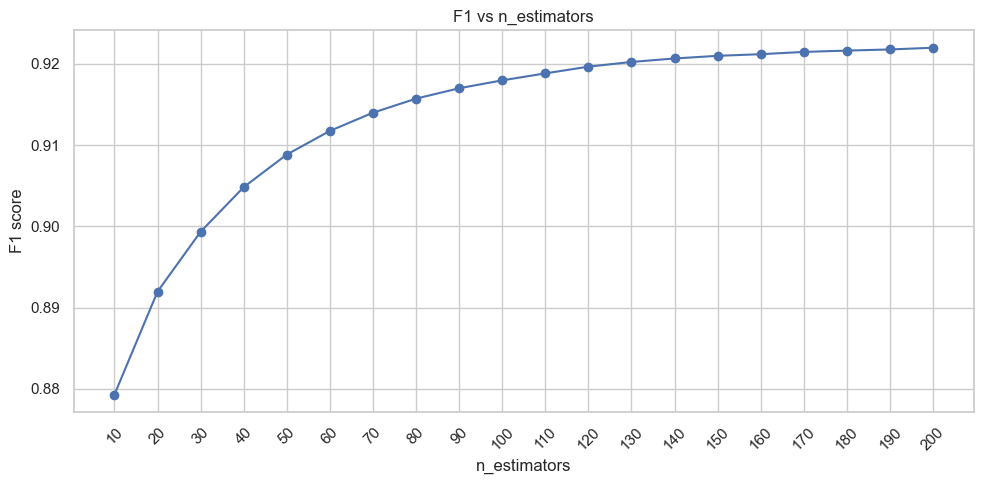

In [ ]:
first_stage_study = joblib.load("first_stage_study.pkl")
best_params = first_stage_study.best_params
best_params["device"] = 'gpu'
best_params["verbosity"] = -1

def second_stage():
    results = []
    params = best_params.copy()
    params['device'] = 'gpu'
    i = 1
    for n in range(10, 201, 10):
        params['n_estimators'] = n
        model = lgb.LGBMClassifier(**params)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
        results.append((n, score))
        print(f"Second Stage: Training model (trial #{i}). n_estimators={n}, score={score}")
        i += 1
    return results

results = second_stage()
print("Вторая стадия подбора гиперпараметров завершилась")

По результатам подбора была построена кривая зависимости значения F1 от количества деревьев, а также кривая прибавки F1 каждые 10 деревьев:

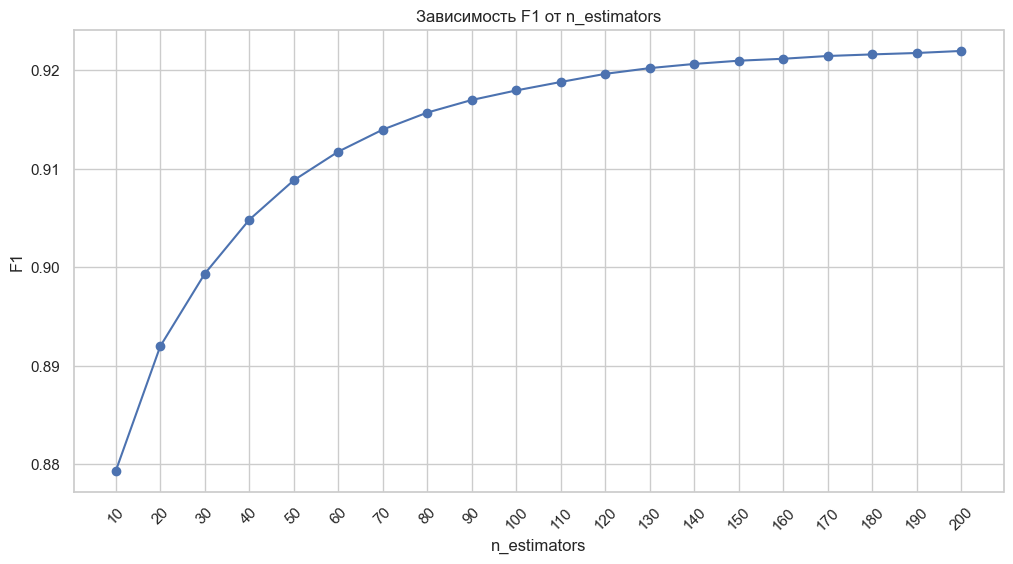

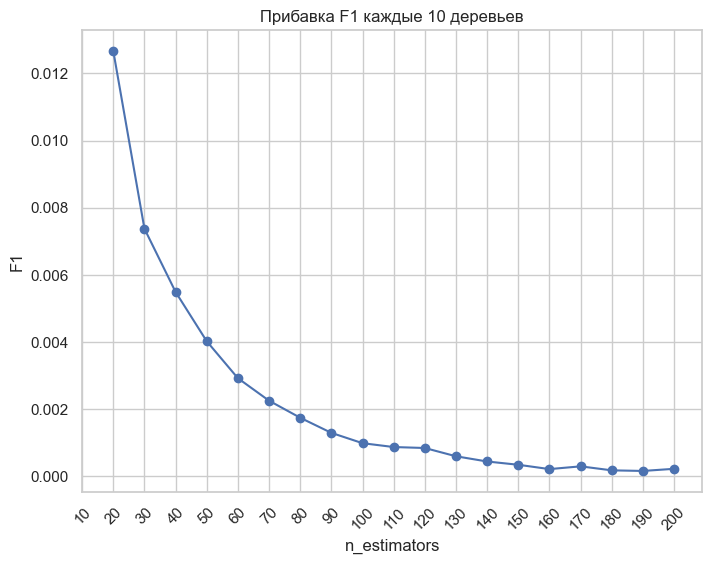

In [ ]:
n_estimators_list, silero_f1_scores = zip(*results)

f1_gains = []
for i in range(1, len(silero_f1_scores)):
    f1_gains.append(silero_f1_scores[i] - silero_f1_scores[i-1])

plt.figure(figsize=(12, 6))
plt.plot(n_estimators_list, silero_f1_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость F1 от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1')
plt.grid(True)
plt.xticks(n_estimators_list, rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(n_estimators_list[1:], f1_gains, marker='o', linestyle='-', color='b')
plt.title('Прибавка F1 каждые 10 деревьев')
plt.xlabel('n_estimators')
plt.ylabel('F1')
plt.grid(True)
plt.xticks(n_estimators_list, rotation=45)
plt.show()

В качестве оптимального количества деревьев было взято 100 деревьев. На данном значении метрика перестает сколь-либо значимо расти.

## Финальное обучение модели

Финальная модель была обучена на всей тренировочной выборке с найденными параметрами.

In [ ]:
first_stage_study = joblib.load("first_stage_study.pkl")
best_params = first_stage_study.best_params
best_params["device"] = 'gpu'
best_params["n_estimators"] = 100
best_params["verbosity"] = -1

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

joblib.dump(model, 'model.pkl')
print(f'Модель сохранена как model.pkl')

Модель сохранена как model.pkl


# Результаты модели

После обучения модель была протестирована на отложенной тестовой выборке. Для анализа качества модели была построена кривая precision-recall. По этой кривой было выбрано оптимальное значение порога классификации, соответствующее максимальному значению F1 $= 0.81$. По итогам классификации на тестовой выборке были получены следующие метрики по классам:
* Класс 0 (не речь):
    * Precision $= 0.9$.
    * Recall $= 0.9$.
    * F1 $= 0.9$.
* Класс 1 (речь):
    * Precision $= 0.81$.
    * Recall $= 0.81$.
    * F1 $= 0.81$.

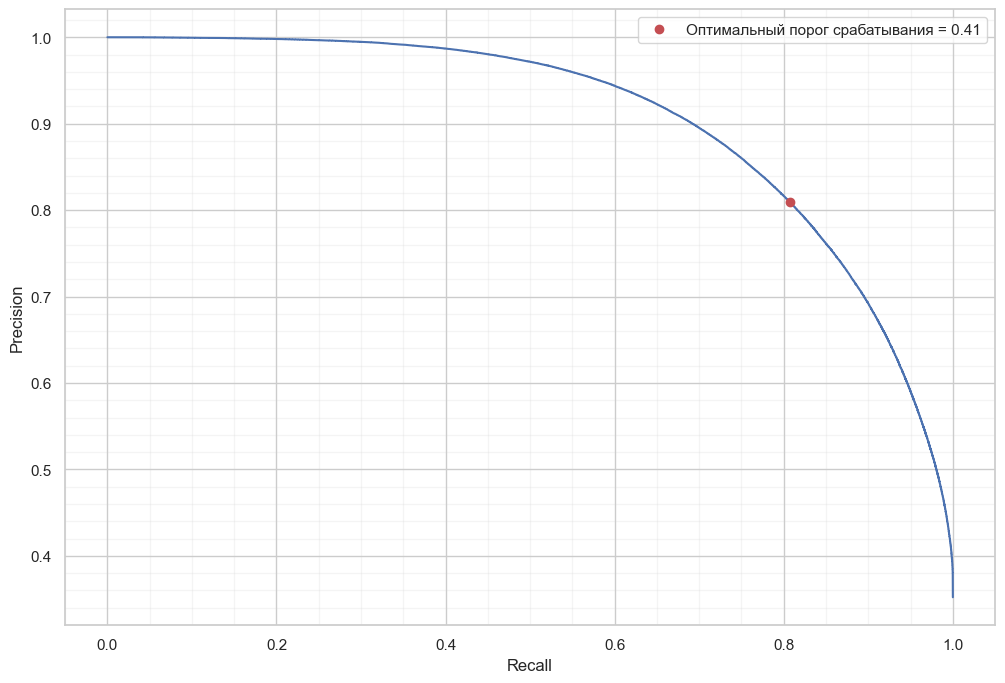

Итоговый Classification report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90    940635
           1       0.81      0.81      0.81    511277

    accuracy                           0.87   1451912
   macro avg       0.85      0.85      0.85   1451912
weighted avg       0.87      0.87      0.87   1451912



In [ ]:
model = joblib.load('model.pkl')

y_pred_proba = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(12, 8))
plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='minor', alpha=0.2)
plt.plot(recall, precision)
plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', label=f'Оптимальный порог срабатывания = {optimal_threshold:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

y_pred = (y_pred_proba >= optimal_threshold).astype(int)

print(f'Итоговый Classification report:\n {classification_report(y_test, y_pred)}')

# Сравнение с другими моделями

In [13]:
test_files_df = files_df[files_df['is_train'] == 0]

def webrtc_vad_test(mode):
    vad = webrtcvad.Vad(mode)

    y_pred = []
    y_test = []

    for row in test_files_df.itertuples():
        y, _ = librosa.load(row.audio_path, sr=SAMPLE_RATE)
        frames = librosa.util.frame(y, frame_length=480, hop_length=240).T

        labels = np.zeros(len(frames), dtype=np.int8)
        if row.labels_path:
            with open(row.labels_path, 'r') as f:
                label_data = f.read()
            for line in label_data.split('\n'):
                if not line:
                    continue
                start, end, is_speech = line.strip().split()
                if is_speech != 'speech':
                    continue
                start_frame = librosa.time_to_frames(float(start), sr=SAMPLE_RATE, hop_length=240)
                end_frame = librosa.time_to_frames(float(end), sr=SAMPLE_RATE, hop_length=240)
                labels[start_frame:end_frame] = 1

        predictions = np.zeros(len(frames), dtype=np.int8)
        for i in range(0, len(predictions)):
            pcm_data = (frames[i] * 32767).astype(np.int16).tobytes()
            predictions[i] = vad.is_speech(pcm_data, SAMPLE_RATE, length=480)
        
        y_pred.extend(predictions)
        y_test.extend(labels)

    return y_pred, y_test

def silero_vad_test():
    vad = load_silero_vad()
    vad_iterator = VADIterator(vad, sampling_rate=SAMPLE_RATE)

    y_pred = []
    y_test = []

    for row in test_files_df.itertuples():
        y, _ = librosa.load(row.audio_path, sr=SAMPLE_RATE)
        frames = librosa.util.frame(y, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH).T

        labels = np.zeros(len(frames), dtype=np.int8)
        if row.labels_path:
            with open(row.labels_path, 'r') as f:
                label_data = f.read()
            for line in label_data.split('\n'):
                if not line:
                    continue
                start, end, is_speech = line.strip().split()
                if is_speech != 'speech':
                    continue
                start_frame = librosa.time_to_frames(float(start), sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
                end_frame = librosa.time_to_frames(float(end), sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
                labels[start_frame:end_frame] = 1

        predictions = np.zeros(len(frames), dtype=np.float32)
        for i in range(0, len(predictions)):
            frame_tensor = torch.from_numpy(frames[i]).unsqueeze(0)
            predictions[i] = vad(frame_tensor, SAMPLE_RATE).item()
        vad_iterator.reset_states()

        y_pred.extend(predictions)
        y_test.extend(labels)

    return y_pred, y_test

TypeError: can't multiply sequence by non-int of type 'list'

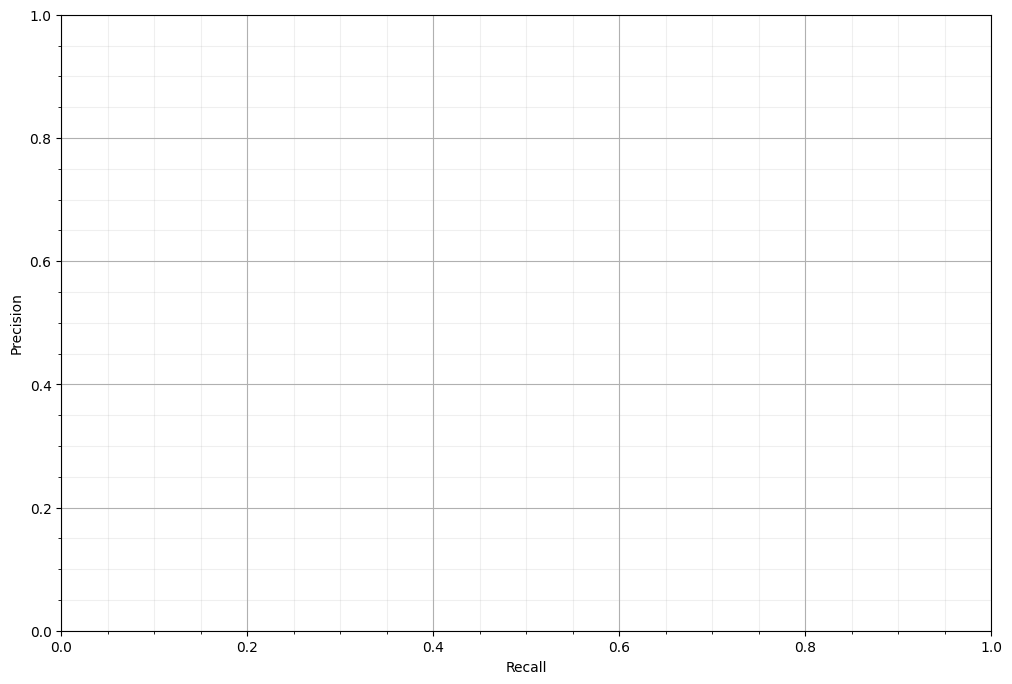

In [ ]:
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.minorticks_on()
plt.grid(True, which='minor', alpha=0.2)
plt.xlabel("Recall")
plt.ylabel("Precision")

# WebRTC VAD
webrtc_precision, webrtc_recall = np.zeros(4), np.zeros(4)
for mode in range(0, 4):
    webrtc_pred, webrtc_test = webrtc_vad_test(mode)
    webrtc_precision[mode] = precision_score(webrtc_test, webrtc_pred)
    webrtc_recall[mode] = recall_score(webrtc_test, webrtc_pred)
webrtc_f1_scores = 2 * (webrtc_precision * webrtc_recall) / (webrtc_precision + webrtc_recall + 1e-9)
plt.plot(webrtc_recall, webrtc_precision, 'ro', label='WebRTC VAD')

# Silero VAD
silero_pred_proba, silero_test = silero_vad_test()
silero_precision, silero_recall, silero_thresholds = precision_recall_curve(silero_test, silero_pred_proba)
silero_f1_scores = 2 * (silero_precision * silero_recall) / (silero_precision + silero_recall + 1e-9)
silero_optimal_idx = np.argmax(silero_f1_scores)
silero_optimal_threshold = silero_thresholds[silero_optimal_idx]
plt.plot(silero_recall, silero_precision, 'g-', label='Silero VAD')
plt.plot(silero_recall[silero_optimal_idx], silero_precision[silero_optimal_idx], 'go')

# Ваша модель
model = joblib.load('model.pkl')
y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
plt.plot(recall, precision, 'b-', label='LightGBM VAD')
plt.plot(recall[optimal_idx], precision[optimal_idx], 'bo')

plt.legend()
plt.show()

In [ ]:

print(f"WebRTC F1: {np.max(webrtc_f1_scores)}")
print(f"Silero VAD F1: {np.max(silero_f1_scores)}")
print(f"LightGBM VAD F1: {np.max(f1_scores)}")

WebRTC F1: 0.5749068111603274
Silero VAD F1: 0.8413545140681217
LightGBM VAD F1: 0.8082943372078324
